# Using Python for User Interface Assessment
## By: Matthew Jacobsen, updated 5/4/2020


So, you've developed an application to provide users features you believe are helpful. How do you determine what improvements are needed or how effective your application is to the end user?  This is a core aspect of research in the area of human-systems interactions and is a key evalaution used in the operational testing of military systems.  

One central theme here is being able to "see what the user sees". While there are multiple software packages available which accomplish this task, it is not always easy to install them on the device/system that a Soldier would be able to employ for field-bases assessment.  Luckily for us, there are methods which enable Python to serve as a stand-in for this.

Let's take a look at how to do this!


## Capturing Video Data

### How to Screen Capture as a Video

One of the primary uses for this type of project is for user analysis, but since it runs on the hardware associated with the system being evaluated, we need to be able to know the memory and CPU impact associated with this.  For monitoring both, we'll have a Google Map view of the Washington, DC metro area that we can navigate around, but also we'll watch the resources used by the system while running the code on the right.

In order to keep the performance impact in view, while preparing for running the video screen capture, I've used Windows resource manager to monitor the CPU utilization and memory used, which hovered around 2 percent and 42 percent, respectively. 

One straightforward methods for accomplishing screen capture is the use of the relatively new package [screen_recorder_sdk] (https://pypi.org/project/screen-recorder-sdk/).  This package, developed by Andrey Parfenov, requires the use of numpy and time libraries to accomplish the needed delays and is capable of outputting a .mp4 video.  The code required to execute this is simple, where you have the screen_recorder.start_video_recording function establishing and performing the screen capture.  The inputs for this function include the output file name, the frame rate, the bit rate, and a flag for whether hardware transforms are being used.  

In [1]:
import numpy as np
import time
from screen_recorder_sdk import screen_recorder

screen_recorder.init_resources ()
    
screen_recorder.start_video_recording('test_video.mp4',30, 60, True)
time.sleep(60)
screen_recorder.stop_video_recording()
screen_recorder.free_resources()

If you'd like to see the results, feel free to take a look.  The video is embedded below.  From the system resources, we can see that this solution results in a minimal impact to the system upon which it is being executed.  There was no noticable increase to either the CPU or memory being used. So, for a simple first go, we have a solution that does a decent job of capturing video and minimizing impact on the system we are testing.  We do have to be careful and adjust the frame and bit rate or have a large external storage drive, as the resulting video (1 minute in length) is 6.2 megabytes.  



<center>
<video width = '720' height = '480' controls src="test_video.mp4" />
</center>

#### Extensions of Screen Capture Video

What we've got above is a spectacular first step towards our goal.  However, if you develop applications for modern systems, you have to be ready to video capture across multiple screens.  Users in a modern environment will undoubtedly use more than one monitor, with the military being no exception to that.  So, can we extend this to cover multiple monitors?  The answer is Yes!  

Python has a wonderful package called [Desktopmagic](https://pypi.org/project/Desktopmagic/) that can be used for exactly this. Let's see what it can do!

For this quick demo, let's just look at getting the screen as an image.  If we can do that, the methodology used in the previous example will easily extend to here.

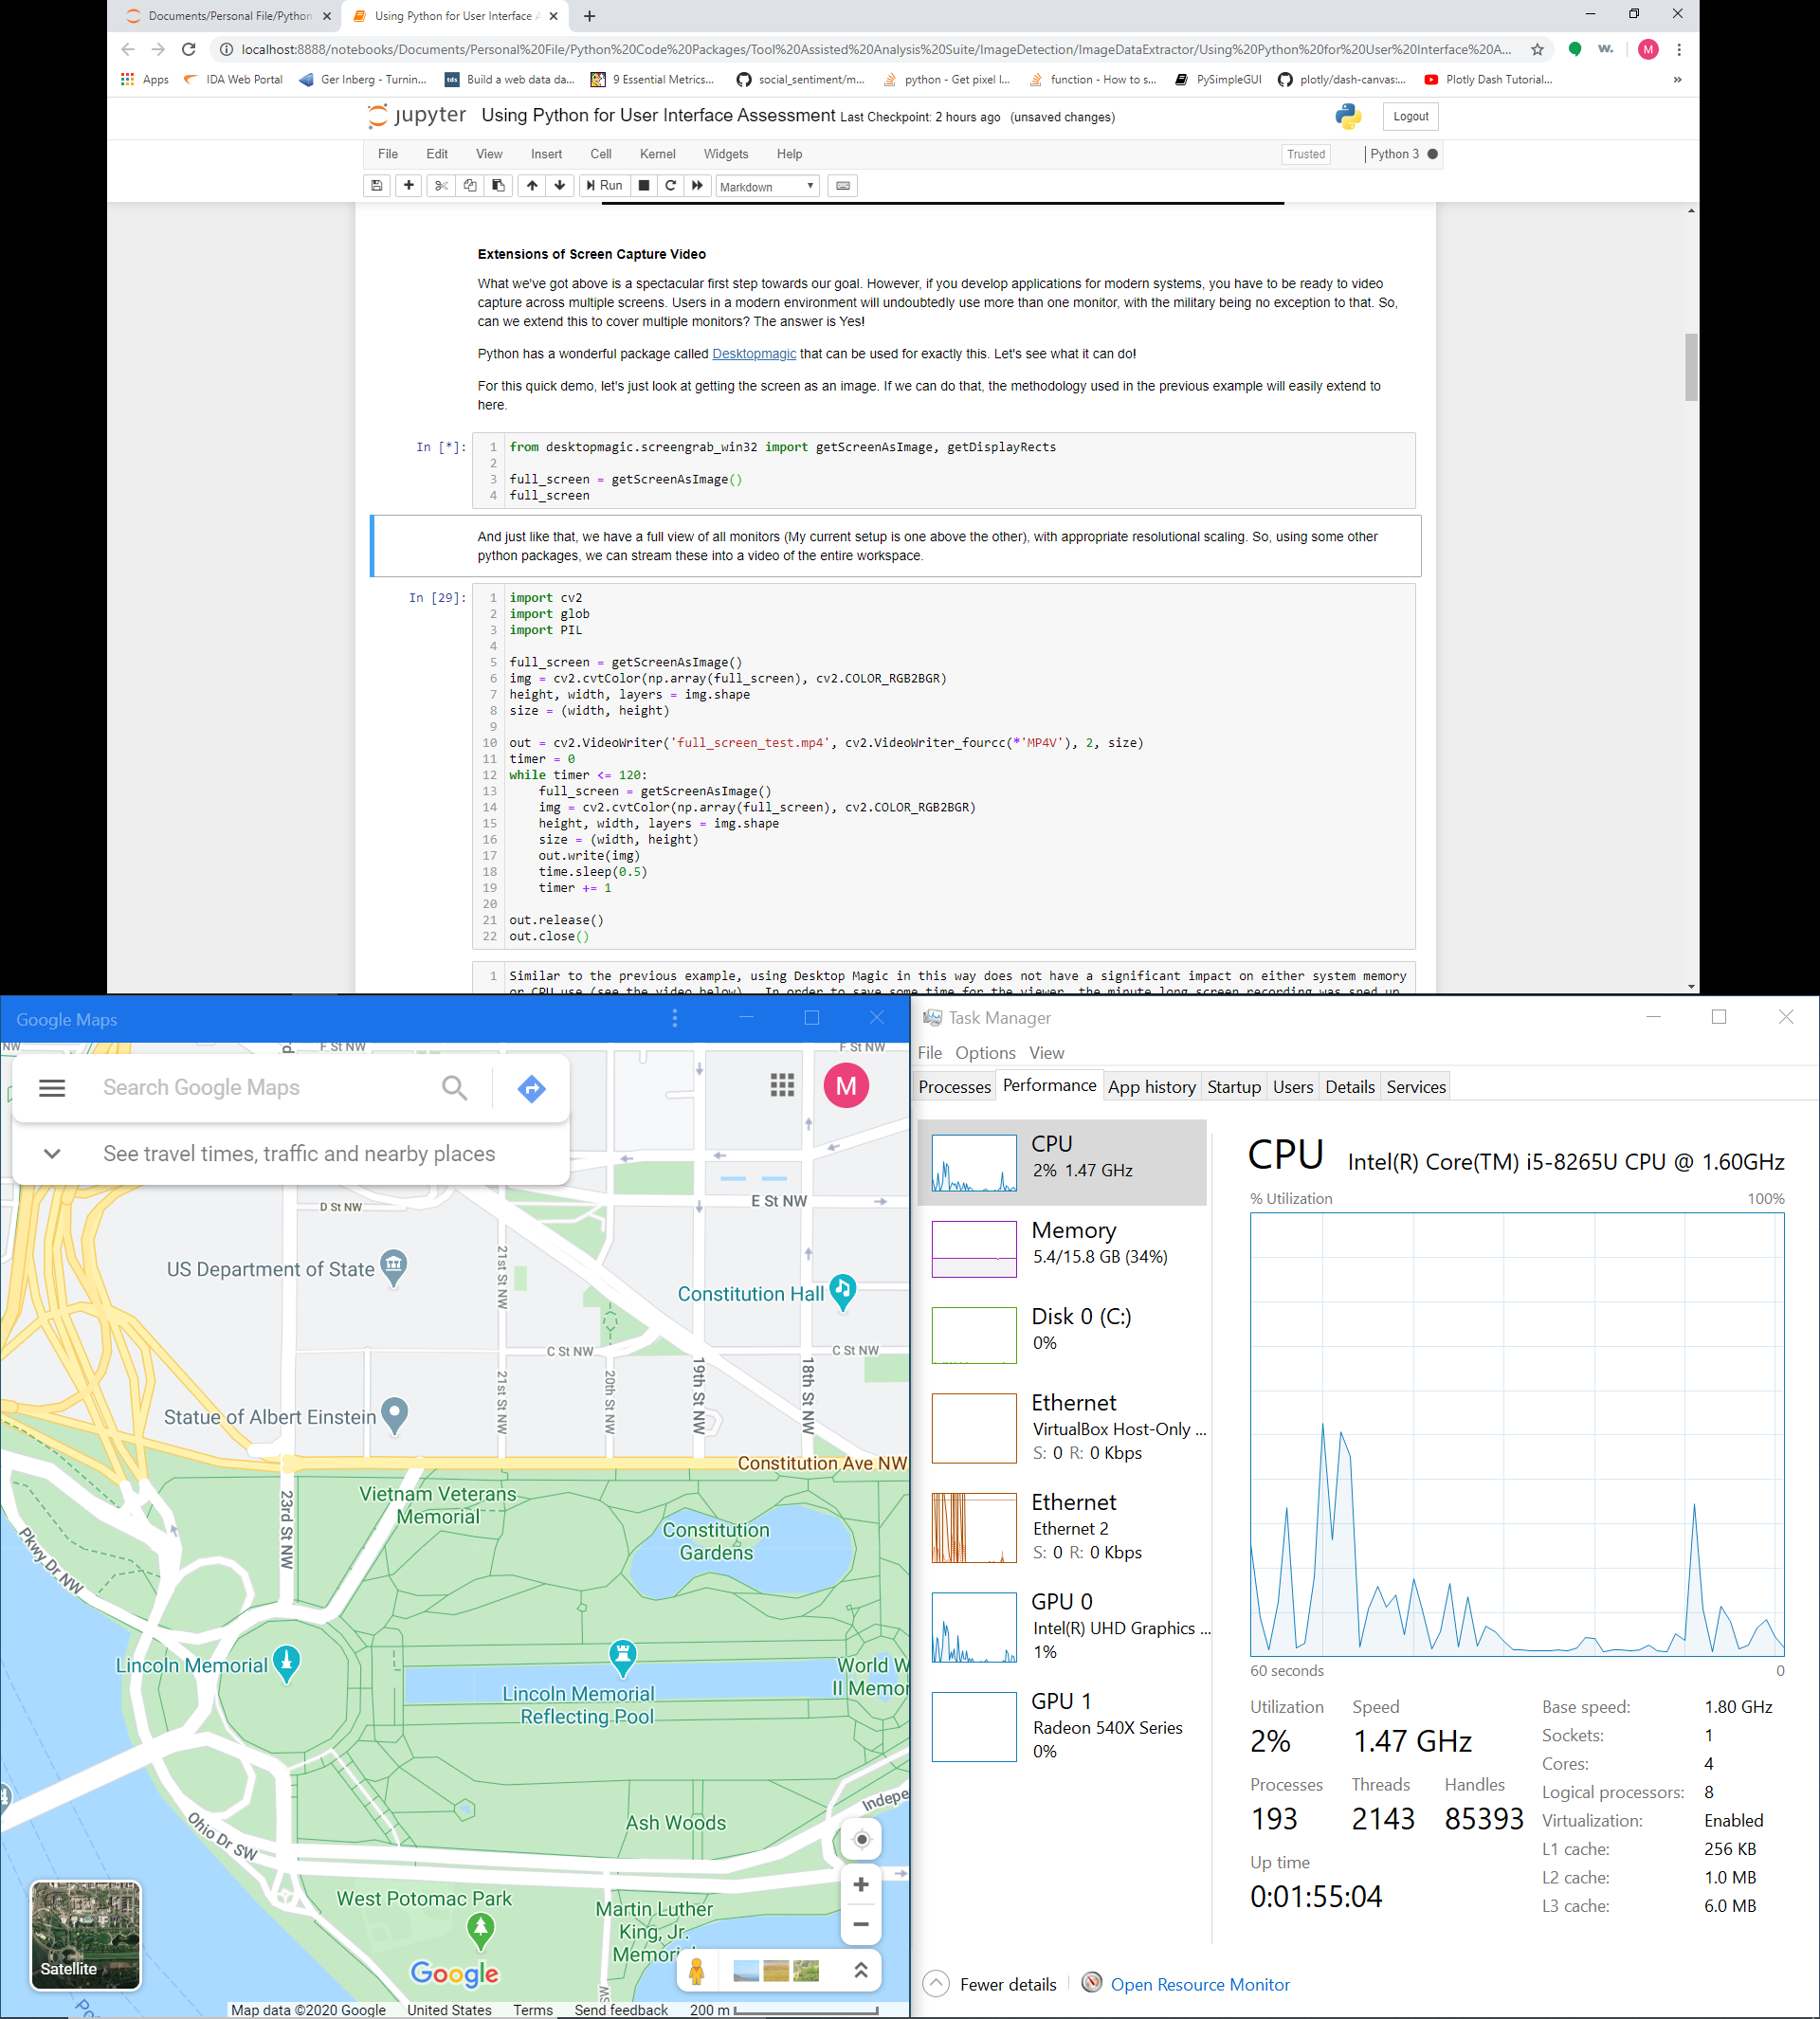

In [2]:
from desktopmagic.screengrab_win32 import getScreenAsImage, getDisplayRects

full_screen = getScreenAsImage()
full_screen

And just like that, we have a full view of all monitors (My current setup is one above the other), with appropriate resolutional scaling. So, using some other python packages, we can stream these into a video of the entire workspace.

In [5]:
import cv2
import glob
import PIL

full_screen = getScreenAsImage()
img = cv2.cvtColor(np.array(full_screen), cv2.COLOR_RGB2BGR)
height, width, layers = img.shape
size = (width, height)
    
out = cv2.VideoWriter('full_screen_test.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 2, size)
timer = 0
while timer <= 120:
    full_screen = getScreenAsImage()
    img = cv2.cvtColor(np.array(full_screen), cv2.COLOR_RGB2BGR)
    height, width, layers = img.shape
    size = (width, height)
    out.write(img)
    time.sleep(0.5)
    timer += 1
    
out.release()
cv2.destroyAllWindows()

Similar to the previous example, using Desktop Magic in this way does not have a significant impact on either system memory or CPU use. The video produced is available along with this notebook (fs_test.mp4). In order to save some time for the viewer, the minute long screen recording was sped up, using a faster frame rate, with the actual screen captures occuring at 1 frame per second. The final MP4 file is similar in size to the previous example. 

## Processing Video Data

### Processing Video Data for Analysis Purposes

Regardless of which method is used, we can now perform user testing with a simple python method for capturing and recording the video data. At this point, let's imagine that we are a Soldier in the middle of an active operation.  Are we likely to sit around all day working on a laptop?  Probably not.  

Given then, we have no good method to predict when and how our users will be using the system we are evaluating, we will likely end up with a large quantity of video looking at the same view (either lock screen or the same screen for extended periods of time).  It would be nice to have a method to extract those frames from a video that gave us "unique" information to simplify the analysis. Although we could ask the same question about whether or not python can help us, we'll avoid this question and say "Of course it can". In order to accomplish this, we need to use a few other packages (VidGear and SKImage) and the code is a bit longer, but let's take a look. First, let's import our packages

In [6]:
from vidgear.gears import CamGear
from skimage.metrics import structural_similarity as ssim

Now, let's get into the actual meat of the process.  We need to initialize the video stream and then iterate through the frames in the video.  The method we are going to use here is a bit cumbersome, but works. (Aside: I plan to edit this in the future to better accomplish this task on a larger scale, but this brute force method works.  It's just not very efficient and better suited for short videos.) For now, we will store each frame with a different index in a dictionary.  

In [7]:
stream = CamGear(source = 'test_video.mp4').start() #Set up the video stream
count = 0  #Initialize the counter
frames = {} #Initialize the storage dictionary

while True:
    frame = stream.read() #Read the frames
    if frame is None:
        break #If the frame is None, assume the end of the video. This is not always true, but it is enough of the time.
    
    frames[count] = frame #Store the frame in the dictionary
    count+=1 #Increment the counter index

stream.stop() #Close the stream

At this point, we have a dictionary object storing all of the frames of the video.  What we now need to do is compare the frames with each other and save out only those that are *unique enough* that there might be meaningful information in the difference. 

In [8]:
index = 0 #Initialize a new counter
reduced_frames = [] #Set up the output list
for frame_key in frames.keys(): # For each key in the frames dictionary
    if index == 0: # If we are on the first key, 
        reduced_frames.append(frames[frame_key]) #Save that frame for output
        last_frame = frames[frame_key] #And set the last frame to that frame
    else: # Otherwise
        frame = frames[frame_key] #The current frame is whatever key we are on's entry in the dictionary
        similarity_index = ssim( #We now compare the last frame (last_frame) with the current frame (frame)
            last_frame, #and specify that the images are multichannel (multicolored)
            frame, 
            multichannel=True)
        if similarity_index < 0.9: # If the images are less than 90% similar
            cv2.imwrite('frame%d.jpg' % index, frame) # Save the current image out, using the index to ID it.
        last_frame = frame #Set the current frame to the last frame
    index += 1 # Increment the counter

Just to demonstrate that this works.  Here's frame number 129 from the video.  

<img src='frame129.jpg'>

So, now we have our somewhat unique screen captures.  There are other things we can do to this, such as auto-cropping the image, but those are really beyond the scope of what is being covered here.  In part, this is because Soldiers will rearrange windows and move things around, so cropping the images does not provide any useful function to us.  

## Analyzing the Video Data

### Extracting Real Space Information from Images

Returning to the mind of our Soldier, one of the critical elements to assess is the accuracy of their "Situational Awareness".  This is really just a fancy term for their awareness of what is going on around them.  In the case of our fictional map application, this means that the data represented to them should be accurate when compared with the data that went into the system, whatever for that is in.  For now, we will keep the data entering the system as abstract and consider just the data represented on the map/screen.  How can we get that out so it is usable?

As with the previous step, this will require a bit more effort (and libraries).  However, we also don't want our analysts to have to custom write code or create specialized script. Since we are using python, let's create a class to help us process this! First, let's import our new modules.

In [9]:
import mgrs #library for converting Military Grid Reference Systems (MGRS) to any other types of coordinates
from PIL import Image #Pillow Library for Image Handling
from win32api import GetSystemMetrics #Library for obtaining system information (screen resolution and size)

Next, let's make a class for storing our coordinates.  In this class, we need to be able to store reference and source data for analysis. For the reference coordinates, we also need to be able to store both the real world coordinates and the image pixel coordinates.  

In [10]:
class CoordinateStore:
    
    def __init__(self):
        
        self.points = [] # Initialize the points list
        self.ref_points = [] # Initialize the reference points list
        self.m = mgrs.MGRS() # Initialize an MGRS class, to internally convert coordinates
        self.converted_points = [] # Initialize the converted points list
        
    def select_point(self, x, y):
        
        self.points.append((x,y)) # Append the point
    
    def select_ref(self, x, y):
        
        item_type = input(
            'What type of reference are you selecting (1=MGRS, 2=Decimal Lat/Long)? '
        ) # Ask the user what type of input they are providing
        if item_type == '1': # If it is MGRS
            item_name = input(
                'Please enter detail of the reference (e.g. 15TWG0000049776): '
            ) # Enter the MGRS Code
            converted_value = self.m.toLatLong(
                item_name.encode()
            ) # Convert the MGRS code
            self.ref_points.append(
                [converted_value, (x,y)]
            ) # Append the converted real world coordinates along with the pixel coordinates

        elif item_type == '2':
            item_name = input(
                'Please enter details of the reference (e.g. [41.999, -93.000]): '
            ) # Prompt for the real world coordinates
            self.ref_points.append(
                [item_name, (x,y)]
            ) # Append the real world coordinates and the pixel coordinates
            
        else:
            print('Not a valid reference. Entry ignored.')  

In this class, we have a few other features, such as the ability to direct convert Military Grid Reference System coordinates to decimal latitude and longitudes, which makes numeric calculations easier on the coordinates.  Beyond this, we will need a function handler to enable our class to direct the clicks on our screen captures of the application map to the appropriate input stream. We will call this the click_director function.  

In [11]:
def click_director(event, x, y, flags, params):
    global cs # Pull our coordinate store into the function
    global img # Pull the image into the function
    if event == cv2.EVENT_LBUTTONDBLCLK: # On a double left click
        cv2.circle(img, (x,y), 3, (255,0,0), -1) # Place a Blue Circle on the clicked location
        cs.select_point(x, y) #Send the coordinates to the coordinate store
    
    elif event == cv2.EVENT_RBUTTONDBLCLK: # On a double right click
        cv2.circle(img, (x,y), 3, (0,255,0), -1) # Place a Green Circle on the clicked location
        cs.select_ref(x,y) # Send the coordinates to the coordinate store

In order to make sure that the data gets entered into our coordinate store (or cs) and that the user facing indicator (a circle on the image) show up appropriately, we define these items as global inputs.  In part, this is because we need to bind this function to the click monitor that will come in the main section of this process.  

Next, we need to compute the average scale factor for each direction in the image.  For this we need a function, which we will call scale_conversion. The version below only uses the first two reference points provided, as an example of how to accomplish a simplified version of this process.  That said, you will achieve better results by including more reference points and taking an average (as well as having a conversion error value to propagate forward).  

In [12]:
def scale_conversion(img_path, cs, height):

    img = Image.open(img_path) # Open the image
    pix = img.load() # Load the image
    
    conv_points = [] # Set up the converted points list
    
    for point in cs.points: # For the point in the cs.points list
        pixel_x = point[0] # Take the X pixel
        pixel_y_org = point[1] # Take the Y pixel
        pixel_y = (height - point[1]) # Convert the Y pixel
        
        # Extract the reference coordinates
        ref_x1 = float(cs.ref_points[0][0][1:-1].split(',')[1])
        ref_y1 = float(cs.ref_points[0][0][1:-1].split(',')[0])
        ref_x2 = float(cs.ref_points[1][0][1:-1].split(',')[1])
        ref_y2 = float(cs.ref_points[1][0][1:-1].split(',')[0])
        
        # Extract the reference pixels
        pix_ref_x1 = cs.ref_points[0][1][0]
        pix_ref_x2 = cs.ref_points[1][1][0]
        pix_ref_y1 = (height - cs.ref_points[0][1][1])
        pix_ref_y2 = (height - cs.ref_points[1][1][1])
        
        # Calculate the x and y difference
        # in both pixels and decimal degrees
        # for scale calculation
        del_phi = ref_x2 - ref_x1
        del_theta = ref_y2 - ref_y1
        del_phi_pix = pix_ref_x2 - pix_ref_x1
        del_theta_pix = pix_ref_y2 - pix_ref_y1
        
        # Calculate the pixel difference for the point 
        # being converted
        del_pix_x = pixel_x - pix_ref_x1
        del_pix_y = pixel_y - pix_ref_y1
        
        # Calculate the new longitude and latitude
        long = ref_x1 + (del_phi/del_phi_pix) * del_pix_x
        lat = ref_y1 + (del_theta/del_theta_pix) * del_pix_y
        
        # Get the color pattern for the pixel 
        value = pix[pixel_x, pixel_y_org]
        
        # Append the converted information
        conv_points.append([lat, long, value])
    
    # Return the converted list
    return conv_points

Now we are ready for the main part of this conversion process.  As you will see, we do some resizing of the image to make it easier to click and then bind the click_director function to the mouse events, so we can obtain data from the map.  Then, we can convert the resulting coordinates to obtain real world positions. Given our earlier work was mostly just playing around with the map, we'll use a pre-made image stored for this type of walkthrough, based upon Google Maps with some overlaid data.

In [14]:
image_path = input(
'Enter the full path of the image for processing: '
) # Query the user for image location

cs = CoordinateStore() # Initialize our CoordinateStore
img = cv2.imread(image_path) # Read in the image
width = GetSystemMetrics(0) # Obtain screen width
height = GetSystemMetrics(1) # Obtain screen height
scale_width = width/img.shape[1] # Obtain ratio of screen to image width
scale_height = height/img.shape[0] # Obtain ratio of screen to image height
scale = min(scale_width, scale_height) # Set the rescaling to the smaller of these two ratios
window_width = int(
    img.shape[1] * scale
) # Rescale the width
window_height = int(
    img.shape[0] * scale
) # Rescale the height

cv2.namedWindow(
    'image',
    cv2.WINDOW_NORMAL
) # Generate a Image Window

cv2.resizeWindow(
    'image',
    window_width,
    window_height
) # Resize the Window

cv2.setMouseCallback('image',click_director) # Bind the function to the mouse actions

cv2.imshow('image',img) #Display the window to the user

cv2.waitKey(0) #Wait until closed

cv2.destroyAllWindows() # Clean up all the window references

# Convert the coordinates
converted_data = scale_conversion(img_path, cs, img.shape[1])

cs.converted_points = converted_data # Store the converted coordinates in our class object

Enter the full path of the image for processing: C:\Users\Matt\Documents\Personal File\Python Code Packages\Tool Assisted Analysis Suite\ImageDetection\ImageDataExtractor\image_for_processing.jpg
What type of reference are you selecting (1=MGRS, 2=Decimal Lat/Long)? 2
Please enter details of the reference (e.g. [41.999, -93.000]): [38.8913, -77.0261]
What type of reference are you selecting (1=MGRS, 2=Decimal Lat/Long)? 2
Please enter details of the reference (e.g. [41.999, -93.000]): [38.9015, -77.0420]


For the purposes of demonstrating what to do with the data we've already gathered, we will use the map portion of frame 129, as shown in the previous section.  Here it is to remind you of what it looks like, cropped to show only the map. 

<img src='image_for_processing.jpg'>

For our two reference points, I've used the Smithsonian Museum of Natural History (38.8913, -77.0261) and DC Metro's Farragut West Station (38.9015, -77.0420).  We'll try to get the coordinates for the White House, Freedom Plaza, Constitution Hall, and the Farragut North Metro Station. The coordinates for these locations is included below to help check our accuracy.  Here's what our coordinates look like.

In [15]:
cs.converted_points

[[38.89774973357016, -77.03656293103448, (200, 221, 216)],
 [38.895865541740676, -77.0307375, (162, 215, 219)],
 [38.89399946714032, -77.04110905172413, (48, 171, 168)],
 [38.902750088809945, -77.03916724137932, (130, 217, 237)]]

In this converted data, we obviously have significantly more precision that we would really have. Recall that our input only contained four decimals of siginficant digits, so anything beyond that is effectively made up data. We'll look at the accuracy of these results shortly.  In addition to the coordinates, we also have information on the BGR (blue, green, red) color levels of the pixel that was clicked on.  Although we will go through other methods to extract information about screen graphics, one of the simplest is to obtain the color combination.  This can be a first step, given that military graphics tend to be color coded, so we can easily determine affiliation based upon the color combination.  

After running the code blocks above, we have converted coordinates in real world space. In order to be clear about how this is accomplished, the section at the end of this example covers the mathematics associated with the conversion. For now, let's check the conversion result against our known coordinates, as reported by Google Maps. 

In [23]:
from haversine import haversine # Geographical Distance Library
import statistics # Basic Statistics Library

real_world_coords = [
    [38.8977, -77.0365], # White House
    [38.8958, -77.0307], # Freedom Plaza
    [38.8940, -77.0412], # Constitution Hall
    [38.9027, -77.0392] # Farragut North Metro
]

comparison_coords = [] # Set up list for combining coordinates

rw_index = 0 # Initialize the index for combining coordinates
for coord_set in cs.converted_points: # For each coordinate set in cs
    lat = coord_set[0] # Extract the Lat and Long
    long = coord_set[1]
    rw_lat = real_world_coords[rw_index][0] # Extract the real world Lat and Long
    rw_long = real_world_coords[rw_index][1]
    comparison_coords.append([[rw_lat, rw_long],[lat, long]]) # Append the pair to the combined list
    rw_index+=1 # Increment the index


error_list = [] # Set up list for errors
for coord_set in comparison_coords: # For each coordinate set
    error_list.append(haversine(coord_set[0],coord_set[1])*1000) # Calculate the error in meters
    
print('Graphical Average Error (meters): ' + str(statistics.mean(error_list))) # Compute the mean value of the errors
print('Graphical Deviation of Error (meters): '+str(statistics.pstdev(error_list))) # Compute the deviation of the errors

Graphical Average Error (meters): 7.465037512330305
Graphical Deviation of Error (meters): 0.7059387562860243


After all of this work, we have created a data pipeline that can (1) obtain video screen capture of a users working monitor or set of monitors and save out, (2) a method for sifting through that video for unique frames and discarding those that are different, and (3) a method for extracting real world positions of the symbols displayed to the user on their map. The end result of this pipeline is a set of data available for quantitative analysis and comparison with both:

- What the user thought they saw on the screen and made decisions off of. 

and

- Data records of what entered that terminal for display. 

Given that the displayed data is all the user can be expected to make a decision on, these both speak to the effectiveness of any application or set of applications that help to maintain Soldier's situational awareness, or for that matter, any other person interacting with a similar function (e.g. GPS or Smart Phone Navigation applications). 

In the end, this is a critical component of the human-systems interactions that we are trying to measure in operational testing and can help to quantify the usefulness and impact on decision making of the application created.  

### Mathematics Associated with the Conversion

In the above sections, we skirted a bit by the mathematics for the sake of discussing the process.  Let's take a step back and walk through the supporting mathematics. So, assume we have an image with an origin in the bottom left (note that we have to reverse the y-axis within python conventions) containing several references with have real world coordinates for, as well as several graphics we want to get real world coordinates for. Here's our setup:

Reference Point 1: 
* Real World Coordinates ($RP1_{Lat}$, $RP1_{Long}$)
* Pixel Coordinates ($RP1_{Px}$, $RP1_{Py}$)
 
Reference Point 2:  
* Real World Coordinates ($RP2_{Lat}$, $RP2_{Long}$)
* Pixel Coordinates ($RP2_{Px}$, $RP2_{Py}$)

Desired Point 1:
* Pixel Coordinates ($P1_{Px}$, $P1_{Py}$)
    

First, we need to figure out our scale for both x (Longitude) and y (Latitude).  Let's take the y scale as an example, since the x scale would be the same.  In the y-direction, we have two equations to define the scale:

$$RP1_{Lat} = a_{0} + a_{1} \times RP1_{Py} (+ a_{2} \times RP1_{Py}^{2})$$

$$RP2_{Lat} = b_{0} + b_{1} \times RP2_{Py} (+ b_{2} \times RP2_{Py}^{2})$$

In both of these, the last term is relevant if a quadratic scaling is anticipated or expected.  However, this will require more points to solve.  Given that these reference points are from the same graph, all of these coefficients (a's and b's) should be equivalent, as we'd expect a single equation to map pixels to geographic coordinates. Let's start off assuming that our linear version is sufficient, but you'd only need more references in order to calculate the other scale factors.  

For a linear version, we'd now get:

$$ RP1_{Lat} = a_{0} + a_{1} \times RP1_{Py}$$

$$ RP2_{Lat} = a_{0} + a_{1} \times RP2_{Py}$$

We *could* take a particular point, say (0,0) for the pixels and their cooresponding real world coordinates.  However, we may not always know the real world coordinates of the origin.  So, in general, we can compute the slope and intercept (so we can actually get the "origin" real world coordinates.  Let's see how this works by starting with solving the first equation for a0. 

$$ a_{0} = RP1_{Lat} - a_{1} \times RP1_{Py} $$

Plugging this into the second equation, we get:

$$ RP2_{Lat} = (RP1_{Lat} - a_{1} \times RP1_{Py}) + a_{1} * RP2_{Py} $$

Which results in

$$ a_{1} = \frac{RP2_{Lat} - RP1_{Lat}}{(RP2_{Py} - RP1_{Py})} $$

Finally, we use this value for the slope of the conversion ($a_{1}$) to get the intercept in the y direction.  

$$a_{0} = RP1_{Lat} - (\frac{RP2_{Lat} - RP1_{Lat}}{RP2_{Py} - RP1_{Py}}) \times RP1_{Py}$$

At this point, we have our Latitude conversion for the entire map.  Following a similar process, we can get the scale and intercept for the Longitude.  

#### Establishing Usable Ranges and Errors

Although our previous process provides the conversion from pixels to geographic coordinates, it does not help us understand the accuracy of the conversion. By adding even a single additional point, we can average the scale values to determine average conversions and error ranges around them.  As a result, it would be better to use somewhere between 4 and 10 reference points to help establish better errors.

We also need to keep in mind that the *range* over which the conversion will be acceptable is determined by the range of the reference points used. Therefore, your reference points should be positioned as far apart as possible. The further apart they are positioned, the greater the likelihood you will need higher terms in the equations above (e.g. quadratic or cubic terms).

In order to find the error range on the scale, we can use built-in functions in Pythons standard library. These would then be propagated through to the resulting coordinates through sum-of-squares methods. This results in errors in the slopes defined (following from the equations in the previous section) as: 

$$\sigma_{a1} = \sqrt{(\frac{\sigma_{RP2_{Lat}}}{RP2_{Lat}})^{2} + (\frac{\sigma_{RP1_{Lat}}}{RP1_{Lat}})^{2} + (\frac{\sigma_{RP2_{Py}}}{RP2_{Py}})^{2} + (\frac{\sigma_{RP1_{Py}}}{RP1_{Py}})^{2}}$$